# <div align='center' style='font-size:36px;color:#336699;'>Image Scaling Attacks on Machine Learning Algorithms: A Cyber Security Perspective 💻</div>

### Libraries

In [1]:
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
import time

### Utility Functions

In [2]:
def imgLoader(imgPath, color_flag=cv2.IMREAD_COLOR):
    try:
        img = cv2.imread(imgPath, color_flag)
        if img is None:
            raise FileNotFoundError(f"Fail to load the image {imgPath}")
        height, width, *channel = img.shape
        if not channel:
            img = img.reshape((height, width, 1))
        return img
    except Exception as e:
        print(e)
        return None

def imgSaver(imgPath, img):
    try:
        cv2.imwrite(imgPath, img)
    except Exception as e:
        print(f'Fail to save the image as {imgPath}: {e}')

def color_shift(sourceImg, targetImg):
    source = cv2.resize(sourceImg, (targetImg.shape[1], targetImg.shape[0]))
    source_hsv = cv2.cvtColor(source, cv2.COLOR_BGR2HSV)
    target_hsv = cv2.cvtColor(targetImg, cv2.COLOR_BGR2HSV)
    target_hsv[:, :, 0:2] = source_hsv[:, :, 0:2]
    target_shifted = cv2.cvtColor(target_hsv, cv2.COLOR_HSV2BGR)
    return target_shifted

def darknet_resize(img, outShape):
    w, h = outShape
    if len(img.shape) == 2:
        img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    img_h, img_w, img_c = img.shape
    w_scale = (img_w - 1.0) / (w - 1.0)
    h_scale = (img_h - 1.0) / (h - 1.0)
    new_img = np.zeros((h, w, img_c))
    part = np.zeros((img_h, w, img_c))
    for k in range(img_c):
        for r in range(img_h):
            for c in range(w):
                val = 0
                if c == w - 1 or img_w == 1:
                    val = img[r, img_w - 1, k]
                else:
                    sx = c * w_scale
                    ix = int(sx)
                    dx = 1.0 * (sx - ix)
                    val = (1 - dx) * img[r, ix, k] + dx * img[r, ix + 1, k]
                part[r, c, k] = val

    for k in range(img_c):
        for r in range(h):
            sy = r * h_scale
            iy = int(sy)
            dy = 1.0 * (sy - iy)
            for c in range(w):
                val = (1 - dy) * part[iy, c, k]
                new_img[r, c, k] = val
            if r == h - 1 or img_h == 1:
                continue
            for c in range(w):
                val = dy * part[iy + 1, c, k]
                new_img[r, c, k] = new_img[r, c, k] + val
    new_img = np.uint8(new_img)
    return new_img

def preprocess_image(img_path, target_size=(30, 30)):
    img = imgLoader(img_path)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  
    return img

### Image Scaling Attack

In [3]:
# Image Scaling Attack Class
class ScalingCamouflageGPU(object):
    def __init__(self, sourceImg=None, targetImg=None, norm='l2', **kwargs):
        self.setSourceImg(sourceImg)
        self.setTargetImg(targetImg)
        self.params = {'func': cv2.resize,
                       'interpolation': cv2.INTER_LINEAR,
                       'norm': norm,
                       'penalty': 10., 
                       'img_factor': 255.}
        keys = self.params.keys()
        for key, value in kwargs.items():
            assert key in keys, ('Improper parameter %s, '
                                 'The parameter should in: '
                                 '%s' % (key, keys))
            self.params[key] = value

    def setResizeMethod(self, func=cv2.resize, interpolation=cv2.INTER_NEAREST):
        self.params['func'] = func
        self.params['interpolation'] = interpolation

    def setSourceImg(self, sourceImg):
        _, __, *channel = sourceImg.shape
        if not channel:
            self.sourceImg = sourceImg[:, :, np.newaxis]
        else:
            self.sourceImg = sourceImg

    def setTargetImg(self, targetImg):
        _, __, *channel = targetImg.shape
        if not channel:
            self.targetImg = targetImg[:, :, np.newaxis]
        else:
            self.targetImg = targetImg

    # inSize: The original input size before resizing.
    # outSize: The output size after resizing.
    def estimateConvertMatrix(self, inSize, outSize):
        inputDummyImg = (self.params['img_factor'] *
                         np.eye(inSize)).astype('uint8')
        outputDummyImg = self._resize(inputDummyImg,
                                      outShape=(inSize, outSize))
        convertMatrix = (outputDummyImg[:, :, 0] /
                         (np.sum(outputDummyImg[:, :, 0], axis=1)).reshape(outSize, 1))
        return convertMatrix

    def _resize(self, inputImg, outShape=(0, 0)):
        func = self.params['func']
        interpolation = self.params['interpolation']

        if func is Image.Image.resize:
            inputImg = Image.fromarray(inputImg)
            outputImg = func(inputImg, outShape, self.params['interpolation'])
            outputImg = np.array(outputImg)
            
        elif func is cv2.resize:
            outputImg = func(inputImg, outShape, interpolation=self.params['interpolation'])
            
        elif func is darknet_resize:
            outputImg = func(inputImg, outShape)
   
        else:
            outputImg = func(inputImg, outShape, self.params['interpolation'])
            outputImg = np.array(outputImg)
            
        if len(outputImg.shape) == 2:
            outputImg = outputImg[:, :, np.newaxis]
        return np.array(outputImg)

    def _getPerturbationGPU_l2(self, convertMatrixL, convertMatrixR, source, target):
        penalty_factor = self.params['penalty']
        p, q, c = source.shape
        a, b, c = target.shape
        convertMatrixL = tf.constant(convertMatrixL, dtype=tf.float32)
        convertMatrixR = tf.constant(convertMatrixR, dtype=tf.float32)
        modifier_init = np.zeros(source.shape)
        source = tf.constant(source, dtype=tf.float32)
        target = tf.constant(target, dtype=tf.float32)
        modifier = tf.Variable(modifier_init, dtype=tf.float32)
        attack = (tf.tanh(modifier) + 1) * 0.5
        x = tf.reshape(attack, [p, -1])
        x = tf.matmul(convertMatrixL, x)
        x = tf.reshape(x, [-1, q, c])
        x = tf.transpose(x, [1, 0, 2])
        x = tf.reshape(x, [q, -1])
        x = tf.matmul(convertMatrixR, x)
        x = tf.reshape(x, [-1, a, c])
        output = tf.transpose(x, [1, 0, 2])
        delta_1 = attack - source
        delta_2 = output - target
        obj1 = tf.reduce_sum(tf.square(delta_1)) / (p * q)
        obj2 = penalty_factor * tf.reduce_sum(tf.square(delta_2)) / (a * b)
        obj = obj1 + obj2
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        for i in range(3000): 
            with tf.GradientTape() as tape:
                tape.watch(modifier)
                attack = (tf.tanh(modifier) + 1) * 0.5
                x = tf.reshape(attack, [p, -1])
                x = tf.matmul(convertMatrixL, x)
                x = tf.reshape(x, [-1, q, c])
                x = tf.transpose(x, [1, 0, 2])
                x = tf.reshape(x, [q, -1])
                x = tf.matmul(convertMatrixR, x)
                x = tf.reshape(x, [-1, a, c])
                output = tf.transpose(x, [1, 0, 2])
                delta_1 = attack - source
                delta_2 = output - target
                obj1 = tf.reduce_sum(tf.square(delta_1)) / (p * q)
                obj2 = penalty_factor * tf.reduce_sum(tf.square(delta_2)) / (a * b)
                obj = obj1 + obj2
            gradients = tape.gradient(obj, [modifier])
            optimizer.apply_gradients(zip(gradients, [modifier]))
            if i % 500 == 0:
                print(f"\nIteration {i}, Obj Value: {obj.numpy()}")
        attack_opt = attack.numpy()
        return attack_opt
    

    def _getPerturbationGPU_l0(self, convertMatrixL, convertMatrixR, source, target):
        penalty_factor = self.params['penalty']
        p, q, c = source.shape
        a, b, c = target.shape
        convertMatrixL = tf.constant(convertMatrixL, dtype=tf.float32)
        convertMatrixR = tf.constant(convertMatrixR, dtype=tf.float32)
        modifier_init = np.zeros(source.shape)
        source = tf.constant(source, dtype=tf.float32)
        target = tf.constant(target, dtype=tf.float32)
        modifier = tf.Variable(modifier_init, dtype=tf.float32)
        feasible_area = np.ones(source.shape)
        prev_obj = np.inf
        while True:
            with tf.GradientTape() as tape:
                attack = source * (1 - feasible_area) + 0.5 * (tf.tanh(modifier) + 1) * feasible_area
                x = tf.reshape(attack, [p, -1])
                x = tf.matmul(convertMatrixL, x)
                x = tf.reshape(x, [-1, q, c])
                x = tf.transpose(x, [1, 0, 2])
                x = tf.reshape(x, [q, -1])
                x = tf.matmul(convertMatrixR, x)
                x = tf.reshape(x, [-1, a, c])
                output = tf.transpose(x, [1, 0, 2])
                delta_1 = attack - source
                delta_2 = output - target
                obj1 = tf.reduce_sum(tf.square(delta_1)) / (p * q)
                obj2 = penalty_factor * tf.reduce_sum(tf.square(delta_2)) / (a * b)
                obj = obj1 + obj2
            gradients = tape.gradient(obj, [modifier])
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
            optimizer.apply_gradients(zip(gradients, [modifier]))
            obj_value = obj.numpy()
            if obj_value > 0.999 * prev_obj:
                break
            prev_obj = obj_value
            grads = gradients[0].numpy()
            change_measure = np.sum(np.abs(grads * delta_1.numpy()) * feasible_area, axis=2)
            tmp = change_measure[np.where(change_measure > 0)].flatten()
            if len(tmp) == 0:
                attack_opt = attack.numpy()
                return attack_opt
            else:
                threshold = np.percentile(tmp, 10)
                valid = np.ones((p, q))
                valid[np.where(change_measure <= threshold)] = 0
                feasible_area = np.repeat(valid[:, :, np.newaxis], c, axis=2)
        attack_opt = attack.numpy()
        return attack_opt
    

    def _getPerturbationGPU_li(self, convertMatrixL, convertMatrixR, source, target):
        penalty_factor = self.params['penalty']
        p, q, c = source.shape
        a, b, c = target.shape
        convertMatrixL = tf.constant(convertMatrixL, dtype=tf.float32)
        convertMatrixR = tf.constant(convertMatrixR, dtype=tf.float32)
        old_modifier = np.arctanh((2 * source - 1) * 0.9999999)
        source = tf.constant(source, dtype=tf.float32)
        target = tf.constant(target, dtype=tf.float32)
        modifier = tf.Variable(np.zeros(source.shape), dtype=tf.float32)
        tau1 = tf.Variable(1.0, dtype=tf.float32)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        for t in range(20):
            modifier.assign(old_modifier)
            for i in range(2000):
                with tf.GradientTape() as tape:
                    attack = (tf.tanh(modifier) + 1) * 0.5
                    x = tf.reshape(attack, [p, -1])
                    x = tf.matmul(convertMatrixL, x)
                    x = tf.reshape(x, [-1, q, c])
                    x = tf.transpose(x, [1, 0, 2])
                    x = tf.reshape(x, [q, -1])
                    x = tf.matmul(convertMatrixR, x)
                    x = tf.reshape(x, [-1, a, c])
                    output = tf.transpose(x, [1, 0, 2])
                    delta_1 = attack - source
                    delta_2 = output - target
                    obj1 = tf.reduce_sum(tf.maximum(0.0, tf.abs(delta_1) - tau1)) / (p * q)
                    obj2 = penalty_factor * tf.reduce_sum(tf.square(delta_2)) / (a * b)
                    obj = obj1 + obj2
                gradients = tape.gradient(obj, [modifier])
                optimizer.apply_gradients(zip(gradients, [modifier]))
                if i % 500 == 0:
                    print(f"\nIteration {i}, Obj Value: {obj.numpy()}")
            tau1.assign(tau1 * 0.9)
        attack_opt = attack.numpy()
        return attack_opt


    def attack(self):
        sourceImg = self.sourceImg
        targetImg = self.targetImg
        sourceHeight, sourceWidth, sourceChannel = sourceImg.shape
        targetHeight, targetWidth, targetChannel = targetImg.shape
        convertMatrixL = self.estimateConvertMatrix(sourceHeight, targetHeight)
        convertMatrixR = self.estimateConvertMatrix(sourceWidth, targetWidth)
        img_factor = self.params['img_factor']
        sourceImg = sourceImg / img_factor
        targetImg = targetImg / img_factor
        source = sourceImg
        target = targetImg
        
        self.info()
        if self.params['norm'] == 'l2':
            attackImg = self._getPerturbationGPU_l2(convertMatrixL, convertMatrixR, source, target)
        elif self.params['norm'] == 'l0':
            attackImg = self._getPerturbationGPU_l0(convertMatrixL, convertMatrixR, source, target)
        elif self.params['norm'] == 'li':
            attackImg = self._getPerturbationGPU_li(convertMatrixL, convertMatrixR, source, target)
        
        print(f"\nMaximum Pixel: {np.max(attackImg)}")
        print(f"Minimum Pixel: {np.min(attackImg)}")
        print('\nImage Scaling Attack Implemented!')
        return np.uint8(attackImg * img_factor)    
        
    def info(self):
        if self.params['func'] is cv2.resize:
            func_name = 'cv2.resize'
            inter_dict = {        
                cv2.INTER_NEAREST: 'cv2.INTER_NEAREST',
                cv2.INTER_LINEAR: 'cv2.INTER_LINEAR',
                cv2.INTER_CUBIC: 'cv2.INTER_CUBIC',
                cv2.INTER_AREA: 'cv2.INTER_AREA',
                cv2.INTER_LANCZOS4: 'cv2.INTER_LANCZOS4'
            }
            inter_name = inter_dict[self.params['interpolation']]
        
        elif self.params['func'] is Image.Image.resize:
            func_name = 'PIL.Image.resize'
            inter_dict = {
                Image.NEAREST: 'Image.NEAREST',
                Image.LANCZOS: 'Image.LANCZOS',
                Image.BILINEAR: 'Image.BILINEAR',
                Image.BICUBIC: 'Image.BICUBIC'
            }
            inter_name = inter_dict[self.params['interpolation']]
        
        elif self.params['func'] is darknet_resize:
            func_name = 'darknet_resize'
            inter_name = 'N/A' 

        sourceShape = (self.sourceImg.shape[1], self.sourceImg.shape[0], self.sourceImg.shape[2])
        targetShape = (self.targetImg.shape[1], self.targetImg.shape[0], self.targetImg.shape[2])

        norm = self.params.get('norm', 'Unknown')
        
        print("\nLet's implement an Image Scaling Attack!")
        print('Source Image Size: %s' % str(sourceShape))
        print('Target Image Size: %s' % str(targetShape))
        print('Resize Method: %s' % func_name)
        print('Interpolation Technique: %s' % inter_name)
        print('Norm: %s' % norm) 

### Attack Execution

In [4]:
def main(sourceImgPath, targetImgPath, attackImgPath, outputImgPath, resizeFunc, interpolation, penalty, imageFactor, norm):
    start_time = time.time()
    sourceImg = imgLoader(sourceImgPath, 1)
    targetImg = imgLoader(targetImgPath, 1)
    
    if sourceImg is None:
        print("Failed to load the source image. Exiting...")
        return
    if targetImg is None:
        print("Failed to load the target image. Exiting...")
        return
    
    targetImg = color_shift(sourceImg, targetImg)
    
    func_lookup = {
        'cv2.resize': cv2.resize,
        'PIL.Image.resize': Image.Image.resize,
        'darknet_resize': darknet_resize
    }
    interpolation_lookup = {
        'cv2.INTER_NEAREST': cv2.INTER_NEAREST,
        'cv2.INTER_LINEAR': cv2.INTER_LINEAR,
        'cv2.INTER_CUBIC': cv2.INTER_CUBIC,
        'cv2.INTER_AREA': cv2.INTER_AREA,
        'cv2.INTER_LANCZOS4': cv2.INTER_LANCZOS4,
        'PIL.Image.NEAREST': Image.NEAREST,
        'PIL.Image.LANCZOS': Image.LANCZOS,
        'PIL.Image.BILINEAR': Image.BILINEAR,
        'PIL.Image.BICUBIC': Image.BICUBIC,
        'N/A': 'N/A'
    }
    sourceImg = imgLoader(sourceImgPath)
    targetImg = imgLoader(targetImgPath)
    
    sc = ScalingCamouflageGPU(sourceImg, targetImg, norm=norm, penalty=penalty, img_factor=imageFactor)
    sc.setResizeMethod(func=func_lookup[resizeFunc], interpolation=interpolation_lookup[interpolation])
   
    sc.setSourceImg(sourceImg)  
    sc.setTargetImg(targetImg)  
    
    attackImg = sc.attack()
    imgSaver(attackImgPath, attackImg)

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 4, 1)
    plt.title("Source Image")
    plt.imshow(cv2.cvtColor(sourceImg, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 4, 2)
    plt.title("Target Image")
    plt.imshow(cv2.cvtColor(targetImg, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 4, 3)
    plt.title("Attack Image")
    plt.imshow(cv2.cvtColor(attackImg, cv2.COLOR_BGR2RGB))
    
    if len(outputImgPath) > 0:
        attackImg = imgLoader(attackImgPath)
        outputImg = sc._resize(attackImg, (targetImg.shape[0], targetImg.shape[1]))
        imgSaver(outputImgPath, outputImg)
        plt.subplot(1, 4, 4)
        plt.title("Output Image")
        plt.imshow(cv2.cvtColor(outputImg, cv2.COLOR_BGR2RGB))
    
    plt.show()

    model = tf.keras.models.load_model('/GTSRB model.keras')
    attackImg_resized = cv2.resize(attackImg, (model.input_shape[1], model.input_shape[2]))
    attackImg_resized = attackImg_resized.astype('float32') / 255.0
    attackImg_resized = np.expand_dims(attackImg_resized, axis=0)

    predictions = model.predict(attackImg_resized)
    predicted_class = np.argmax(predictions)

    class_names = {
        0: 'Speed limit (20km/h)',
        1: 'Speed limit (30km/h)',
        2: 'Speed limit (50km/h)',
        3: 'Speed limit (60km/h)',
        4: 'Speed limit (70km/h)',
        5: 'Speed limit (80km/h)',
        6: 'End of speed limit (80km/h)',
        7: 'Speed limit (100km/h)',
        8: 'Speed limit (120km/h)',
        9: 'No passing',
        10: 'No passing veh over 3.5 tons',
        11: 'Right-of-way at intersection',
        12: 'Priority road',
        13: 'Yield',
        14: 'Stop',
        15: 'No vehicles',
        16: 'Veh > 3.5 tons prohibited',
        17: 'No entry',
        18: 'General caution',
        19: 'Dangerous curve left',
        20: 'Dangerous curve right',
        21: 'Double curve',
        22: 'Bumpy road',
        23: 'Slippery road',
        24: 'Road narrows on the right',
        25: 'Road work',
        26: 'Traffic signals',
        27: 'Pedestrians',
        28: 'Children crossing',
        29: 'Bicycles crossing',
        30: 'Beware of ice/snow',
        31: 'Wild animals crossing',
        32: 'End speed + passing limits',
        33: 'Turn right ahead',
        34: 'Turn left ahead',
        35: 'Ahead only',
        36: 'Go straight or right',
        37: 'Go straight or left',
        38: 'Keep right',
        39: 'Keep left',
        40: 'Roundabout mandatory',
        41: 'End of no passing',
        42: 'End no passing veh > 3.5 tons'
    }

    for img_path, img_type in [(attackImgPath, "Attack Image"), (outputImgPath, "Output Image")]:
        processed_img = preprocess_image(img_path)
        prediction = model.predict(processed_img)
        predicted_class = np.argmax(prediction)
        print(f"The model classifies the {img_type} as class {predicted_class} ({class_names[predicted_class]}).")

    time_cost = time.time() - start_time
    print("\nDuration:", time_cost)

### Attack Testing and Classfication
The model is vulnerable to size (30, 30, 3) and methods of interpolation ['bilinear', 'lanczos3', 'mitchellcubic']

### L2 Norm


Let's implement an Image Scaling Attack!
Source Image Size: (1400, 889, 3)
Target Image Size: (54, 54, 3)
Resize Method: cv2.resize
Interpolation Technique: cv2.INTER_CUBIC
Norm: l2

Iteration 0, Obj Value: 0.30151331424713135

Iteration 500, Obj Value: 0.007021624129265547

Iteration 1000, Obj Value: 0.002966126659885049

Iteration 1500, Obj Value: 0.0022688857279717922

Iteration 2000, Obj Value: 0.0020307537633925676

Iteration 2500, Obj Value: 0.001921721501275897

Maximum Pixel: 0.9927026629447937
Minimum Pixel: 0.02330908179283142

Image Scaling Attack Implemented!


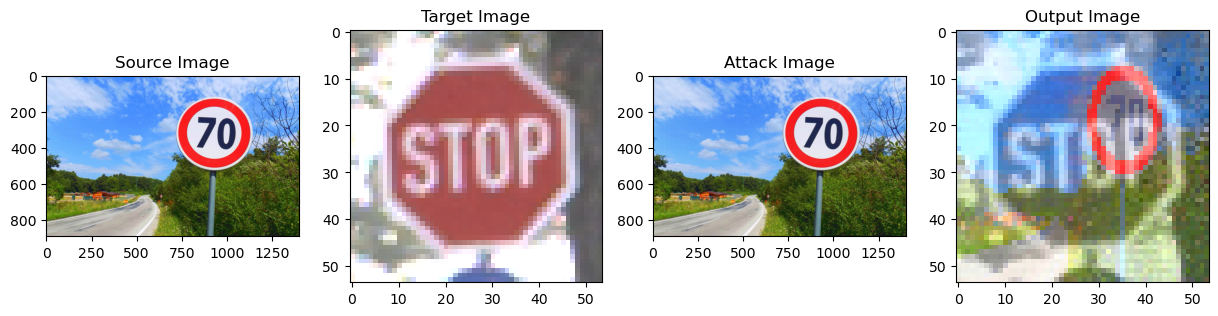



1/1 [==============================] - 0s 41ms/step
The model classifies the Attack Image as class 25 (Road work).
1/1 [==============================] - 0s 50ms/step
The model classifies the Output Image as class 14 (Stop).

Duration: 407.73074746131897


In [5]:
sourceImgPath = '/70.png'
targetImgPath = '/Stop.png'
attackImgPath = 'L2_ATTACK.jpg'
outputImgPath = 'L2_OUTPUT.jpg'

main(sourceImgPath, targetImgPath, attackImgPath, outputImgPath, 'cv2.resize', 'cv2.INTER_CUBIC', 0.01, 255, 'l2')